### Testing Evo

#### Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch_geometric
from torch_geometric.nn import GCNConv
import IPython
from IPython.display import display, HTML, Image
from torch_geometric.loader import DataLoader

from generator import generate_organism
from cell import Cell
from organism import Organism
from GNCAmodel import GNCA
from GNCAConv import Conv
from visualizer import Visualizer
from evo_trainer import Evo_Trainer
from enums import EnvironmentType

#### Train the network

In [2]:
n = 100
popsize = 10
generations = 100
batch_size = 2
wrap_around = True
with_global_node = False
env_type = EnvironmentType.Clusters
food_amount = 50
scale = 2
name = 'hidden3'

#TODO ADD settings like number of clusters and food in clusters..., std of clusters..

#device = torch.device('mps')
device = torch.device('cpu')
trainer = Evo_Trainer(n, device, batch_size, wrap_around, with_global_node, food_amount, env_type, popsize, scale)
network = Conv(device=device, batch_size=batch_size, wrap_around=wrap_around, with_global_node=with_global_node)

2023-04-03 22:51:15,842	INFO worker.py:1528 -- Started a local Ray instance.


[2023-04-03 22:51:25] INFO     <94968> evotorch.core: Instance of `Custom_NEProblem` (id:11555584752) -- The `dtype` for the problem's decision variables is set as torch.float32
[2023-04-03 22:51:25] INFO     <94968> evotorch.core: Instance of `Custom_NEProblem` (id:11555584752) -- `eval_dtype` (the dtype of the fitnesses and evaluation data) is set as torch.float32
[2023-04-03 22:51:25] INFO     <94968> evotorch.core: Instance of `Custom_NEProblem` (id:11555584752) -- The `device` of the problem is set as cpu
[2023-04-03 22:51:25] INFO     <94968> evotorch.core: Instance of `Custom_NEProblem` (id:11555584752) -- The number of actors that will be allocated for parallelized evaluation is 10
[2023-04-03 22:51:25] INFO     <94968> evotorch.core: Instance of `Custom_NEProblem` (id:11555584752) -- Number of GPUs that will be allocated per actor is None


/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/evotorch/tools/misc.py:1107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = torch.tensor(data, **kwargs)


In [18]:
generations = 200

In [19]:
trainer.train(generations, name)

         iter : 101
     stepsize : ReadOnlyTensor(0.0353)
    mean_eval : 197.60000610351562
pop_best_eval : 250.0
  median_eval : 186.0

         iter : 102
     stepsize : ReadOnlyTensor(0.0352)
    mean_eval : 246.89999389648438
pop_best_eval : 360.0
  median_eval : 245.5

         iter : 103
     stepsize : ReadOnlyTensor(0.0352)
    mean_eval : 82.6500015258789
pop_best_eval : 137.0
  median_eval : 73.0

         iter : 104
     stepsize : ReadOnlyTensor(0.0352)
    mean_eval : 280.95001220703125
pop_best_eval : 397.5
  median_eval : 283.5

         iter : 105
     stepsize : ReadOnlyTensor(0.0352)
    mean_eval : 224.3000030517578
pop_best_eval : 306.5
  median_eval : 211.5

         iter : 106
     stepsize : ReadOnlyTensor(0.0351)
    mean_eval : 135.75
pop_best_eval : 190.0
  median_eval : 134.0

         iter : 107
     stepsize : ReadOnlyTensor(0.0351)
    mean_eval : 162.6999969482422
pop_best_eval : 207.5
  median_eval : 159.5

         iter : 108
     stepsize : ReadOnly

In [20]:
network = trainer.get_trained_network()

In [21]:
#trainer.logger_df.from_csv('../logger/' + name + '.csv')
#network.load_state_dict(torch.load('../models/' + name + '.pth'))

In [22]:
#network = trainer.problem.parameterize_net(trainer.searcher.status['best'][0])
network = trainer.problem.parameterize_net(trainer.searcher.status['center'][0])
#network = trainer.problem.parameterize_net(trainer.searcher.status['obj0_pop_best'])

In [23]:
#trainer.searcher.status

#### Visualize trained network

In [24]:
graphs = [generate_organism(n, device, with_global_node, food_amount, env_type, scale).toGraph() for _ in range(batch_size)]
loader = DataLoader(graphs, batch_size=batch_size)
graph = next(iter(loader))
visualizer = Visualizer(wrap_around, batch_size, scale)
network.batch_size = batch_size
network(graph, 0)

DataBatch(x=[3400, 11], edge_index=[1, 0], device=[2], subsize=[2], energy=[2], velocity=[2], border_cost=[2], food_reward=[2], dead_cost=[2], visible_food=[2], food_avg_dist=[2], food_avg_degree=[2], food_search_movement=[2], batch=[3400], ptr=[3])

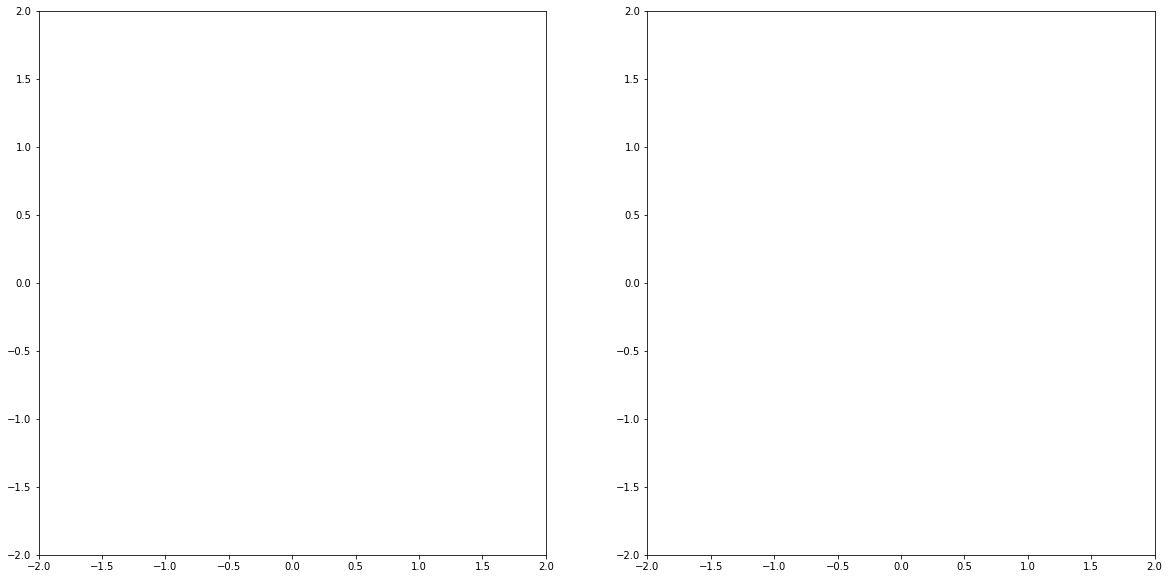

In [25]:
anim = visualizer.animate_organism(graph, network, food=30, frames=100) #test environment
#visualizer.save_animation_to_gif(anim, name, fps=10, dpi=200) #beautiful

#anim = visualizer.animate_organism(graph, network, food=30, frames=200) #visualize model
visualizer.save_animation_to_gif(anim, name, fps=10, dpi=50) #fast

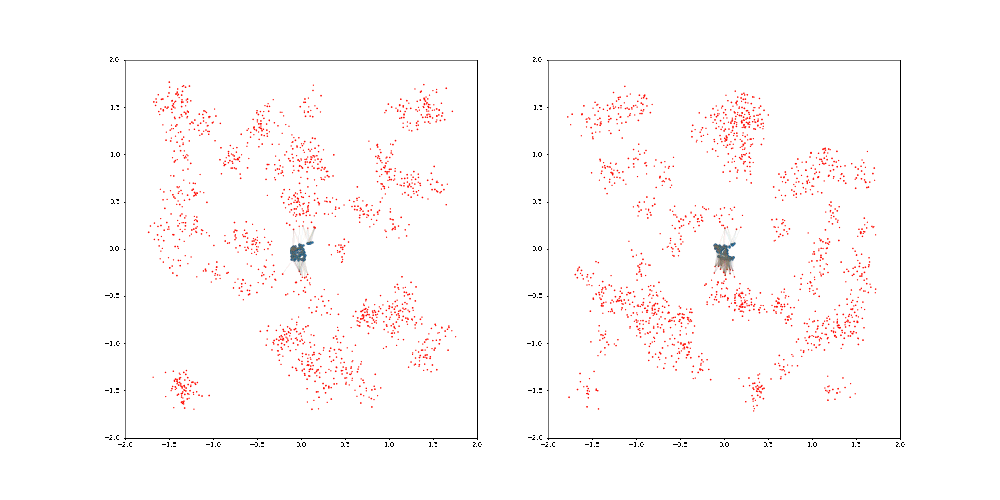

In [26]:
Image('../animation/' + name + '.gif')

In [27]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

#### Visualization of loss:

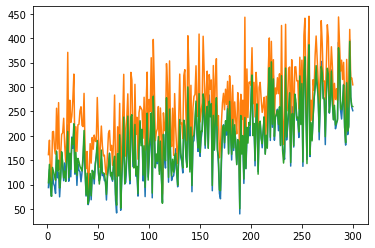

In [28]:
import matplotlib.pyplot as plt
losses = trainer.logger_df
#print(losses)
#plt.plot(losses.stepsize)

plt.plot(losses.median_eval)
plt.plot(losses.pop_best_eval)
plt.plot(losses.mean_eval)
#plt.legend(('median_eval', 'pop_best_eval', 'mean eval'))
plt.show()

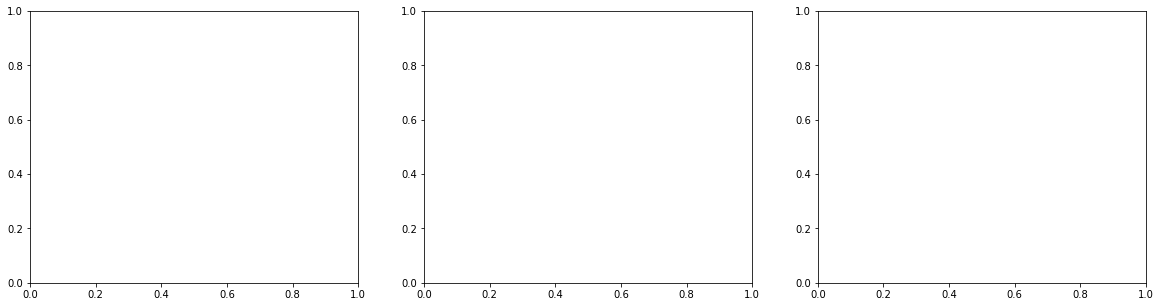

In [29]:
trainer.logger_df
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
fig.suptitle('')
plt.show()

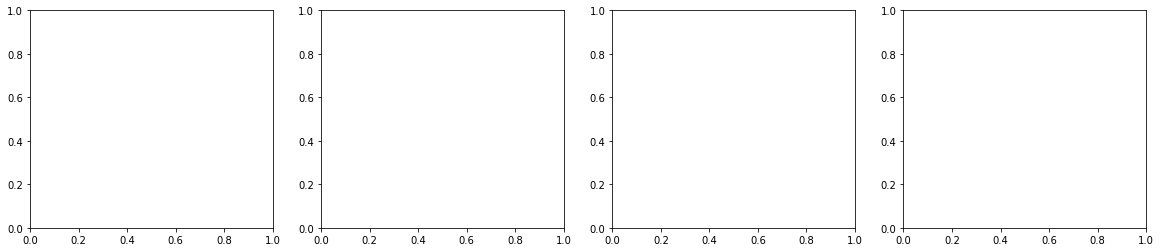

In [30]:
fig, axs = plt.subplots(1, 4, figsize=(20,4))

In [31]:
from torch_geometric.utils import to_networkx
import networkx as nx
from torch_geometric.data import Data
import time

#network = GNCA(device, batch_size, wrap_around, with_global_node)
graphs = [generate_organism(n, device, with_global_node, food_amount, env_type, scale).toGraph() for _ in range(batch_size)]
loader = DataLoader(graphs, batch_size=batch_size)
graph = next(iter(loader))
graph = network(graph, 10)